In [1]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam
import pickle
print("import done")

Using TensorFlow backend.


import done


In [2]:
#https://github.com/debadridtt/A-Review-of-Different-Word-Embeddings-for-Sentiment-Classification-using-Deep-Learning/blob/master/LSTM%20Experiment.ipynb

In [3]:
DATA_FILE = 'C:/Users/khmar/Desktop/ISSUE/dataset/CSV/data_ameliorate/data.csv'
df = pd.read_csv(DATA_FILE,delimiter=';',encoding='UTF-8')
print(df.head())

                                                text     label
0  I had ordered a data cable, got a very well fi...  NOTISSUE
1                                   Love This Phone.  NOTISSUE
2                I get a very well finished product.  NOTISSUE
3                            I could not be happier.  NOTISSUE
4  I was looking for this headset for a long time...  NOTISSUE


In [4]:
df['label'].value_counts() #imbalanced Dataset


NOTISSUE    2030
ISSUE       2025
Name: label, dtype: int64

In [5]:
df.shape

(4055, 2)

In [6]:
msk = np.random.rand(len(df)) < 0.7 # Splitting into train(70%) and test(30%) randomly

In [7]:
train_df=df[msk]
test_df=df[~msk]

In [8]:
print(train_df.shape)
print(test_df.shape)

(2842, 2)
(1213, 2)


In [9]:
print('Checking target values for train data:\n')
print(train_df['label'].value_counts(),'\n')
print('Checking target values for test data:\n')
print(test_df['label'].value_counts())

Checking target values for train data:

ISSUE       1438
NOTISSUE    1404
Name: label, dtype: int64 

Checking target values for test data:

NOTISSUE    626
ISSUE       587
Name: label, dtype: int64


In [10]:
train_df['label'].value_counts()


ISSUE       1438
NOTISSUE    1404
Name: label, dtype: int64

In [11]:
x_train=train_df['text']
y_train=train_df['label']
x_test=test_df['text']
y_test=test_df['label']

In [12]:
texts_train = x_train.astype(str)
texts_test = x_test.astype(str)

In [13]:
MAX_NB_WORDS = 20000
maxlen = 120  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

### GLoVe Embedding 200 

In [14]:
x_train=train_df['text']
y_train=train_df['label']
x_test=test_df['text']
y_test=test_df['label']

In [15]:
MAX_NB_WORDS = 20000
maxlen = 120  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

In [16]:
texts_train = x_train.astype(str)
texts_test = x_test.astype(str)

In [17]:
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS, char_level=False)
tokenizer.fit_on_texts(texts_train)
sequences = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)

In [18]:
file_tok = 'C:/Users/khmar/model_file/LSTM_token_glove_200.sav'
pickle.dump(tokenizer, open(file_tok, 'wb'))

In [30]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                     padding="pre", truncating="post")
test_data = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH, padding="pre",
                          truncating="post")

In [19]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 4100 unique tokens.


In [20]:
MAX_SEQUENCE_LENGTH = 200
#pad sequences are used to bring all sentences to same size.
# pad sequences with 0s
x_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', x_train.shape)
print('Shape of data test tensor:', x_test.shape)

Shape of data tensor: (2842, 200)
Shape of data test tensor: (1213, 200)


In [21]:
y_train = y_train.map({"NOTISSUE": 1, "ISSUE" : 0 })
y_test = y_test.map({"NOTISSUE": 1, "ISSUE" : 0 })

In [22]:
# load the whole embedding into memory
embeddings_index = {}
f = open('C:/Users/khmar/Desktop/GLoVE/glove.6B.200d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [23]:
embedding_matrix = np.zeros((len(word_index) + 1, 200))
#Found 1489 unique tokens : word_index
#print(len(word_index) + 1) #### 1490 
#print(word_index.items()) ### unique tokens : words :word_index
#print('embedding_matrix',embedding_matrix)
out_of_vocab={}
for word, i in word_index.items():
    #print(i)
    embedding_vector = embeddings_index.get(word)
    #print('embedding_vector' ,embedding_vector )
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        #print('word: ', word)
        embedding_matrix[i] = embedding_vector
        #print('embedding_matrix :',embedding_matrix[i] )
        # words not found in embedding index will be all-zeros.
    if embedding_vector is  None:
        #print('word not found :',word)
        out_of_vocab[i] = word

In [24]:
#file_output= "C:/Users/khmar/Desktop/out_of_vocab_glove_200_without_text_processing.txt"
#with open(file_output, "w") as f1:
    #for word, i in out_of_vocab.items():
        #print(out_of_vocab.get(word))
        #f1.write(out_of_vocab.get(word))

In [25]:
f'There are {len(out_of_vocab)} out of vocab '

'There are 258 out of vocab '

In [26]:
model_glove= Sequential()
model_glove.add(Embedding(len(word_index) + 1,
                            200,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False))
model_glove.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2,input_shape=(1,)))
model_glove.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [27]:
model_glove.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [31]:
%%time
model_glove.fit(data, y_train,
          batch_size=batch_size,
          epochs=2,
          validation_data=(test_data, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 2842 samples, validate on 1213 samples
Epoch 1/2
2842/2842 [==============================] - 26s 9ms/step - loss: 0.5845 - acc: 0.6890 - val_loss: 0.5119 - val_acc: 0.7601
Epoch 2/2
2842/2842 [==============================] - 23s 8ms/step - loss: 0.4696 - acc: 0.7850 - val_loss: 0.4695 - val_acc: 0.7782
Wall time: 50.4 s


In [32]:
scores = model_glove.evaluate(x_test, y_test,
                            batch_size=batch_size)
print("%s: %.2f%%" % (model_glove.metrics_names[0], scores[0] * 100))
print("%s: %.2f%%" % (model_glove.metrics_names[1], scores[1] * 100))

1213/1213 [==============================] - 3s 2ms/step
loss: 46.95%
acc: 77.82%


In [33]:
file_model = 'C:/Users/khmar/model_file/LSTM_model_glove_200.sav'
pickle.dump(model_glove, open(file_model, 'wb'))

In [34]:
# Save the model
model_glove.save('lstm_model_glove_200_DATA_without_text_processing.sav')

### Prediction

In [35]:
#model_file='lstm_model_glove_200_DATA_without_text_processing.sav'
#token_file='C:/Users/khmar/model_file/LSTM_token_glove_200d_DATA.sav'
#model = pickle.load(open(model_file,'rb'))
#token = pickle.load(open(token_file,'rb'))

#import numpy as np 
#from keras.models import load_model # To save and load model

# Load the model
#my_model = load_model(model_file)
#my_model= model_glove

In [42]:
def prediction(input_file,output_file):
    df= pd.DataFrame(columns=['label', 'text'])
    data = pd.read_csv(input_file,delimiter=';')
    inputt=data.text
    x_input = inputt.values
    for i in x_input:
        seq = tokenizer.texts_to_sequences(i)
        seqs = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
        yhat = model_glove.predict(seqs)
        class_pred = model_glove.predict_classes(seqs)
        classe1 = prediction_classe1(class_pred[0][0])
        df=df.append({'label':classe1,'text':i},ignore_index=True)
    df.to_csv(output_file,sep=';')
    return data,df

In [43]:
def prediction_classe(prob):
    x=""
    if prob > 0.7:
          x = 'NOTISSUE'
    if prob <= 0.7:
          x = 'ISSUE'
    return x

In [44]:
def prediction_classe1(class_pred):
    if class_pred == 1:
        x = 'ISSUE'
    if class_pred== 0:
        x = 'NOTISSUE'
    return x

In [39]:
## prediction of one word

In [46]:
seq= tokenizer.texts_to_sequences("mediocre product")
seqs = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
class_pred = model_glove.predict_classes(seqs)
#print(class_pred)
y = model_glove.predict(seqs)
#print(y)
classe1 = prediction_classe1(class_pred[0][0])
#print(class_pred[0])
print(classe1)

ISSUE


In [47]:
### prediction of all data

In [49]:
input_file ='C:/Users/khmar/Desktop/ISSUE/dataset/CSV/data_ameliorate/data.csv'
output_file ='C:/Users/khmar/Desktop/ISSUE/dataset/CSV/data_ameliorate/DATA_pred_glove_200.csv'
prediction(input_file,output_file)

(                                                   text     label
 0     I had ordered a data cable, got a very well fi...  NOTISSUE
 1                                      Love This Phone.  NOTISSUE
 2                   I get a very well finished product.  NOTISSUE
 3                               I could not be happier.  NOTISSUE
 4     I was looking for this headset for a long time...  NOTISSUE
 5              my headset starts ringing for no reason.     ISSUE
 6     Display is excellent and camera is as good as ...  NOTISSUE
 7                           Battery life is also great!  NOTISSUE
 8     The worst phone I have ever had.... Only had i...     ISSUE
 9     Not a good item.. It worked for a while then s...     ISSUE
 10    This is so embarassing and also my ears hurt i...     ISSUE
 11                     Protects the phone on all sides.  NOTISSUE
 12    This is a VERY average phone with bad battery ...     ISSUE
 13    Clear Skype Calls, Long Battery Life, Long Range.  NOTI

In [50]:
data_predict= pd.read_csv(output_file ,delimiter=';',encoding='latin-1')
print(data_predict.head())

   Unnamed: 0     label                                               text
0           0     ISSUE  I had ordered a data cable, got a very well fi...
1           1  NOTISSUE                                   Love This Phone.
2           2     ISSUE                I get a very well finished product.
3           3     ISSUE                            I could not be happier.
4           4     ISSUE  I was looking for this headset for a long time...


In [51]:
data_predict['label'].value_counts() 

ISSUE       2854
NOTISSUE    1201
Name: label, dtype: int64

In [52]:
### confessin matrix

In [53]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(df.label,data_predict.label)
print(cm)

[[1411  614]
 [1443  587]]


In [54]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

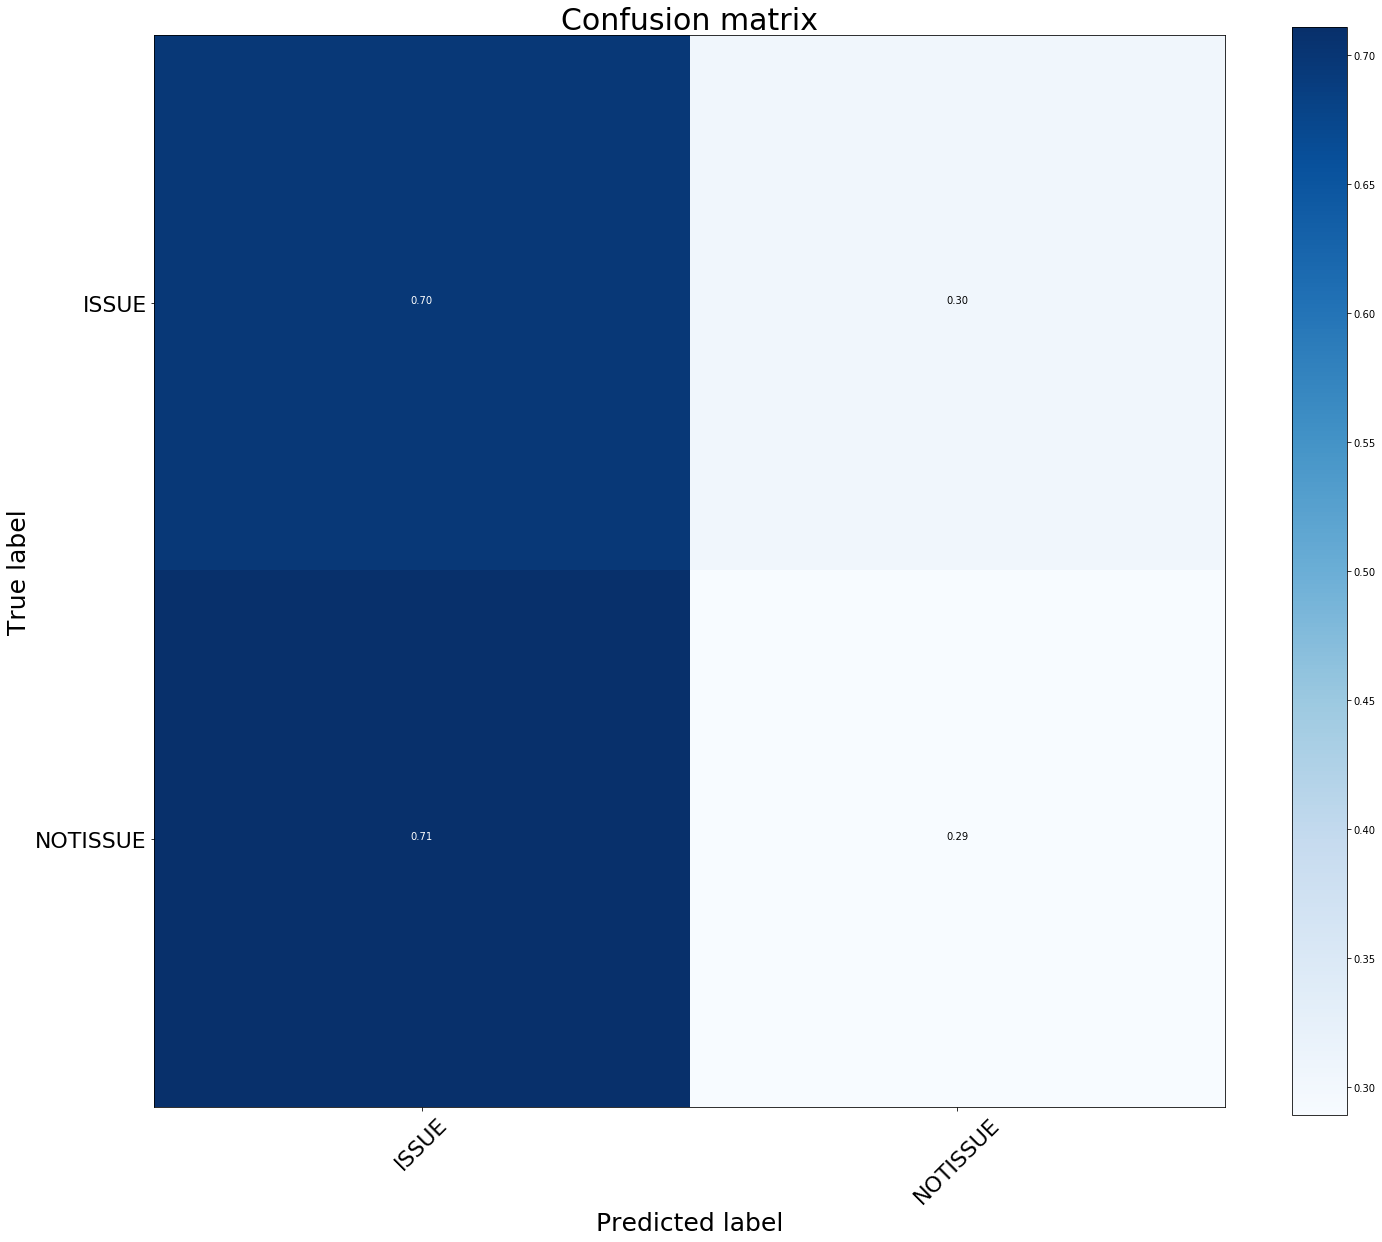

In [55]:
cnf_matrix = confusion_matrix(df.label, data_predict.label)
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=['ISSUE','NOTISSUE'], title="Confusion matrix")
plt.show()

In [56]:
#######

In [57]:
########

In [58]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(y_true = df.label, y_pred = data_predict.label)

In [59]:
import json
print(json.dumps(cf.tolist(), indent=2))

[
  [
    1411,
    614
  ],
  [
    1443,
    587
  ]
]


In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

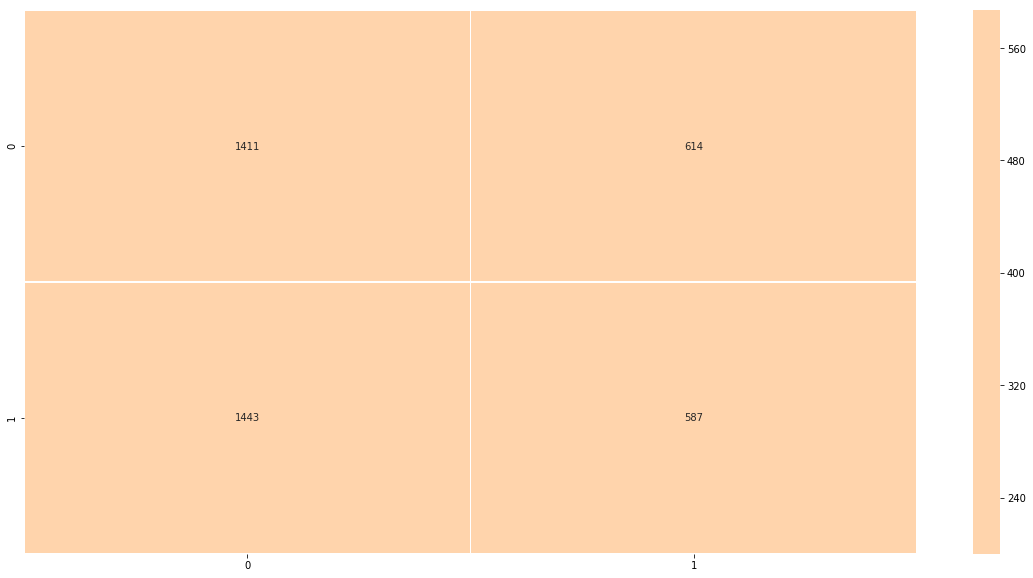

In [61]:
plt.figure(figsize=(20,10))
ax = sns.heatmap(cf, annot=True, fmt="d",linewidths=.5, center = 90, vmax = 200)

In [62]:
from sklearn.metrics import classification_report, accuracy_score

print('accuracy %s' % accuracy_score(data_predict.label, df.label))
print(classification_report(df.label, data_predict.label,target_names=['ISSUE','NOTISSUE']))

accuracy 0.49272503082614055
              precision    recall  f1-score   support

       ISSUE       0.49      0.70      0.58      2025
    NOTISSUE       0.49      0.29      0.36      2030

   micro avg       0.49      0.49      0.49      4055
   macro avg       0.49      0.49      0.47      4055
weighted avg       0.49      0.49      0.47      4055



In [63]:
def false(input_file,output_file,falses_file):
    diff= pd.DataFrame(columns=['true_label','pred_label', 'Text'])
    data = pd.read_csv(input_file,delimiter=';')
    data_pred = pd.read_csv(output_file,delimiter=';')
    input1 = data.label
    input2 = data_pred.label
    x=data.text.values
    x_input1 = input1.values
    x_input2 = input2.values
    for i in range(len(x_input1)):
        if x_input1[i]!=x_input2[i]:
            diff = diff.append({'true_label':x_input1[i],'pred_label':x_input2[i], 'Text':x[i]},ignore_index=True)
    diff.to_csv(falses_file,sep=';')
    return diff

In [64]:
falses_file='C:/Users/khmar/Desktop/ISSUE/dataset/CSV/DATA_pred_glove_200.csv'
diff=false(input_file,output_file,falses_file)
print(diff)

     true_label pred_label                                               Text
0      NOTISSUE      ISSUE  I had ordered a data cable, got a very well fi...
1      NOTISSUE      ISSUE                I get a very well finished product.
2      NOTISSUE      ISSUE                            I could not be happier.
3      NOTISSUE      ISSUE  I was looking for this headset for a long time...
4      NOTISSUE      ISSUE                        Battery life is also great!
5         ISSUE   NOTISSUE  Not a good item.. It worked for a while then s...
6      NOTISSUE      ISSUE  After trying many many handsfree gadgets this ...
7      NOTISSUE      ISSUE                                      Magical Help.
8         ISSUE   NOTISSUE                                Poor sound quality.
9      NOTISSUE      ISSUE                       The best phone in market :).
10     NOTISSUE      ISSUE                               It worked very well.
11     NOTISSUE      ISSUE  The company shipped my product very 

In [65]:
#from sklearn.metrics import confusion_matrix,classification_report
#print('\n*Classification LSTM Word2Vec:\n', classification_report(y_test, model_glove.predict(x_test)))